## Realise fuzzy transfer learning model on one synthetic dataset

## Setup

In [ ]:
import os
import torch.backends.cudnn as cudnn

import sys
sys.path.append("..")

from torch.nn import init
import random
import torch
import numpy as np

SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

cuda = False
cudnn.benchmark = False

## Prepare synthetic dataset

First, we generate the interval-valued Gaussian dataset

In [ ]:
from sklearn.datasets import make_blobs

def Gau_data(sys_examples, random_state):

    num_inputs = 2

    s_features, s_labels = make_blobs(n_features=num_inputs, n_samples=sys_examples, centers=3, random_state=random_state,
                                      cluster_std=[0.9, 2, 4], center_box=(0, 20.0))
    t_features, t_labels = make_blobs(n_features=num_inputs, n_samples=sys_examples, centers=3, random_state=random_state,
                                      cluster_std=[1.5, 2, 5], center_box=(-25, 5.0))

    bias1_s = np.random.uniform(0.5, 1, (sys_examples, num_inputs))
    bias2_s = np.random.uniform(2, 5, (sys_examples, num_inputs))
    bias1_t = np.random.uniform(0.5, 1, (sys_examples, num_inputs))
    bias2_t = np.random.uniform(2, 5, (sys_examples, num_inputs))

    s_interval = np.zeros((s_features.shape[0], s_features.shape[1] * 2))

    for i in range(s_features.shape[1]):
        for j in range(s_features.shape[0]):
            s_interval[j, 2 * i] = s_features[j, i] - bias1_s[j, i]
            s_interval[j, 2 * i + 1] = s_features[j, i] + bias2_s[j, i]

    t_interval = np.zeros((t_features.shape[0], t_features.shape[1] * 2))

    for i in range(t_features.shape[1]):
        for j in range(t_features.shape[0]):
            t_interval[j, 2 * i] = t_features[j, i] - bias1_t[j, i]
            t_interval[j, 2 * i + 1] = t_features[j, i] + bias2_t[j, i]

    return s_features, s_interval, s_labels, t_features, t_interval, t_labels

Next, we give an visualization of some synthetic data.

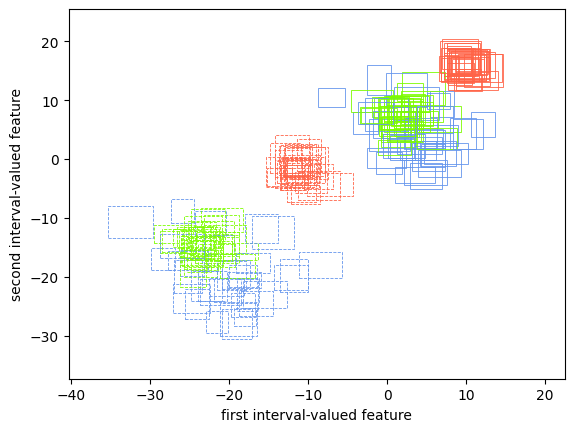

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch

sys_examples = 100
s_features, s_interval, s_labels, t_features, t_interval, t_labels = Gau_data(sys_examples = 150, random_state = SEED)

feature_number = 2
class_number = 3

s_min = np.min(s_interval)
s_max = np.max(s_interval)

t_min = np.min(t_interval)
t_max = np.max(t_interval)

fig, ax = plt.subplots()

for i in range(sys_examples):
    if s_labels[i] == 0:
        rect = pch.Rectangle((s_interval[i, 0], s_interval[i, 2]), s_interval[i, 1] - s_interval[i, 0], s_interval[i, 3] - s_interval[i, 2], linestyle="-", linewidth=0.6, edgecolor='tomato', facecolor='none')
        ax.add_patch(rect)
    elif s_labels[i] == 1:
        rect = pch.Rectangle((s_interval[i, 0], s_interval[i, 2]), s_interval[i, 1] - s_interval[i, 0], s_interval[i, 3] - s_interval[i, 2], linestyle="-", linewidth=0.6, edgecolor='lawngreen', facecolor='none')
        ax.add_patch(rect)
    else:
        rect = pch.Rectangle((s_interval[i, 0], s_interval[i, 2]), s_interval[i, 1] - s_interval[i, 0], s_interval[i, 3] - s_interval[i, 2], linestyle="-", linewidth=0.6, edgecolor='cornflowerblue', facecolor='none')
        ax.add_patch(rect)
    if t_labels[i] == 0:
        rect = pch.Rectangle((t_interval[i, 0], t_interval[i, 2]), t_interval[i, 1] - t_interval[i, 0], t_interval[i, 3] - t_interval[i, 2], linestyle="--", linewidth=0.6, edgecolor='tomato', facecolor='none')
        ax.add_patch(rect)
    elif t_labels[i] == 1:
        rect = pch.Rectangle((t_interval[i, 0], t_interval[i, 2]), t_interval[i, 1] - t_interval[i, 0], t_interval[i, 3] - t_interval[i, 2], linestyle="--", linewidth=0.6, edgecolor='lawngreen', facecolor='none')
        ax.add_patch(rect)
    else:
        rect = pch.Rectangle((t_interval[i, 0], t_interval[i, 2]), t_interval[i, 1] - t_interval[i, 0], t_interval[i, 3] - t_interval[i, 2], linestyle="--", linewidth=0.6, edgecolor='cornflowerblue', facecolor='none')
        ax.add_patch(rect)

plt.xlim(xmin=min(s_min, t_min)-5, xmax=max(s_max, t_max)+2)
plt.ylim(ymin=min(s_min, t_min)-2, ymax=max(s_max, t_max)+5)
plt.xlabel("first interval-valued feature")
plt.ylabel("second interval-valued feature")
# plt.legend(['source samples from class 1', 'target samples from class 1', 'source samples from class 2', 'target samples from class 2', 'source samples from class 3', 'target samples from class 3'], loc='upper left', fontsize=8)
plt.show()

## Define fuzzy transformation fuction and prepare dataloader

In [ ]:
def DFdataset_s(feature, labels, beta, feature_number, batch_size):
    encry_number = feature.shape[0]
    # VAL
    feature_VAL = np.array([])
    for i in range(feature_number):
        M = (2 * beta / 3 + 1 / 6) * feature[:, 2 * i] + (5 / 6 - 2 * beta / 3) * feature[:, 2 * i + 1]
        feature_VAL = np.concatenate((feature_VAL, M))
    feature_VAL = (feature_VAL.reshape(feature_number, encry_number)).T
    feature_l = np.zeros((encry_number, feature_number))
    for j in range(feature_number):
        feature_l[:, j] = feature[:, 2 * j]
    feature_r = np.zeros((encry_number, feature_number))
    for j in range(feature_number):
        feature_r[:, j] = feature[:, 2 * j + 1]

    source = torch.utils.data.TensorDataset(torch.tensor(feature_VAL, dtype=torch.float32), torch.tensor(labels).long())
    source_loader = torch.utils.data.DataLoader(source, batch_size, drop_last=True)
    source_l = torch.utils.data.TensorDataset(torch.tensor(feature_l, dtype=torch.float32), torch.tensor(labels).long())
    source_l_loader = torch.utils.data.DataLoader(source_l, batch_size, drop_last=True)
    source_r = torch.utils.data.TensorDataset(torch.tensor(feature_r, dtype=torch.float32), torch.tensor(labels).long())
    source_r_loader = torch.utils.data.DataLoader(source_r, batch_size, drop_last=True)

    return source_loader, source_l_loader, source_r_loader

def DFdataset_t(feature, labels, beta, feature_number, batch_size):
    encry_number = feature.shape[0]
    # VAL
    feature_VAL = np.array([])
    for i in range(feature_number):
        M = (2 * beta / 3 + 1 / 6) * feature[:, 2 * i] + (5 / 6 - 2 * beta / 3) * feature[:, 2 * i + 1]
        feature_VAL = np.concatenate((feature_VAL, M))
    feature_VAL = (feature_VAL.reshape(feature_number, encry_number)).T
    feature_l = np.zeros((encry_number, feature_number))
    for j in range(feature_number):
        feature_l[:, j] = feature[:, 2 * j]
    feature_r = np.zeros((encry_number, feature_number))
    for j in range(feature_number):
        feature_r[:, j] = feature[:, 2 * j + 1]

    target = torch.utils.data.TensorDataset(torch.tensor(feature_VAL, dtype=torch.float32), torch.tensor(labels).long(), torch.arange(0, len(labels)).long())
    target_loader = torch.utils.data.DataLoader(target, batch_size, drop_last=True)
    target_l = torch.utils.data.TensorDataset(torch.tensor(feature_l, dtype=torch.float32), torch.tensor(labels).long())
    target_l_loader = torch.utils.data.DataLoader(target_l, batch_size, drop_last=True)
    target_r = torch.utils.data.TensorDataset(torch.tensor(feature_r, dtype=torch.float32), torch.tensor(labels).long())
    target_r_loader = torch.utils.data.DataLoader(target_r, batch_size, drop_last=True)

    return target_loader, target_l_loader, target_r_loader

s_features, s_interval, s_labels, t_features, t_interval, t_labels = Gau_data(sys_examples = 2000, random_state = SEED)

batch_size = 100
beta = 1 ####################################################################### shape parameter
source_loader, source_l_loader, source_r_loader = DFdataset_s(s_interval, s_labels, beta, feature_number, batch_size)
target_loader, target_l_loader, target_r_loader = DFdataset_t(t_interval, t_labels, beta, feature_number, batch_size)

## Define model structure of T-S fuzzy model

In [ ]:
import torch.nn as nn
import torch.nn.utils.weight_norm as weightNorm

#define feature extrator
class Feature_ext(nn.Module):

    def __init__(self, input_size):
        super(Feature_ext, self).__init__()
        self.feature_classifier = nn.Sequential()
        self.feature_classifier.add_module('f_fc1', nn.Linear(input_size, 100))
        self.feature_classifier.add_module('f_bn1', nn.BatchNorm1d(100))
        self.feature_classifier.add_module('f_relu1', nn.ReLU(True))
        self.feature_classifier.add_module('f_drop1', nn.Dropout())
        self.feature_classifier.add_module('f_fc2', nn.Linear(100, 100))
        self.feature_classifier.add_module('f_bn2', nn.BatchNorm1d(100))
        self.feature_classifier.add_module('f_relu2', nn.ReLU(True))
        self.feature_classifier.add_module('f_drop2', nn.Dropout())
        self.feature_classifier.add_module('f_fc3', nn.Linear(100, 100))
        self.feature_classifier.add_module('f_bn3', nn.BatchNorm1d(100))
        self.feature_classifier.add_module('f_relu3', nn.ReLU(True))
        self.feature_classifier.add_module('f_drop3', nn.Dropout())

    def forward(self, input_data):
        feature = self.feature_classifier(input_data)

        return feature

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

class feat_classifierf(nn.Module):
    def __init__(self, class_num, bottleneck_dim=256, rule_num=65, type="linear"):
        super(feat_classifierf, self).__init__()
        self.type = type
        self.class_num = class_num
        self.rule_num = rule_num
        self.fcs = nn.Sequential()
        self.fc = {}
        for i in range(rule_num):
            if type == 'wn':
                self.fc[i] = weightNorm(nn.Linear(bottleneck_dim, class_num), name="weight")
                self.fc[i].apply(init_weights)
            else:
                self.fc[i] = nn.Linear(bottleneck_dim, class_num)
                self.fc[i].apply(init_weights)
            self.fcs.add_module('fc_'+str(i), self.fc[i])

    def forward(self, x):
        out=[]
        for i in range(self.rule_num):
            outi = self.fcs[i](x)
            #xi.type
            out.append(outi)
        #x = self.fc(x)
        return out

## Define training process

First, we define some basic function to caculate the learning loss of T-S fuzzy model and interval MMD loss.

In [ ]:
from torch import optim
from torch.autograd import Variable
from functools import partial
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix

class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True, reduction=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.reduction = reduction
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).cpu(), 1)
        if self.use_gpu: targets = targets
        targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).sum(dim=1)
        if self.reduction:
            return loss.mean()
        else:
            return loss
        return loss

def norm_fea(fea):
    fea = torch.cat((fea, torch.ones(fea.size(0), 1)), 1)
    fea = (fea.t() / torch.norm(fea, p=2, dim=1)).t()
    return fea

def clu_mem(fea, cen):
    fea = norm_fea(fea).numpy()
    dist_c = cdist(fea, cen, 'cosine')
    dist_a = (1 / (1e-8 + dist_c)).sum(axis=1)
    dist_a = np.expand_dims(dist_a, axis=1)
    dda = dist_a.repeat(cen.shape[0], axis=1)
    # mem_ship = nn.Softmax(dim=1)(torch.from_numpy(1/(1e-8 + (dist_c*dda)))).numpy()
    mem_ship = torch.from_numpy(1 / (1e-8 + (dist_c * dda))).numpy()

    return mem_ship

def srcnet_output(inputs, netF, netC, cen):
    feas = netF(inputs)
    mem_ship = clu_mem(feas.detach().cpu(), cen)
    tar_rule = np.argsort(-mem_ship, axis=1)
    mem_ship = torch.from_numpy(mem_ship).float()
    outputs = netC(feas)

    return mem_ship, tar_rule, outputs

def cal_output_sel(output, member, tar_rule, src_rule_num, class_number):
    outputs = torch.zeros([output[0].shape[0], class_number])
    for i in range(src_rule_num):  # rule_num
        for j in range(output[0].shape[0]):
            outputs[j, :] = outputs[j, :] + member[j, tar_rule[j, i]] * output[tar_rule[j, i]][j, :]
    return outputs

def update_anc_src(aff, all_fea, labelset, K):
    initc0 = aff.transpose().dot(all_fea)
    initc0 = initc0 / (1e-8 + aff.sum(axis=0)[:, None])

    return initc0


def update_cen_src(aff, all_fea, labelset, K):
    initc0 = aff.transpose().dot(all_fea)
    initc0 = initc0 / (1e-8 + aff.sum(axis=0)[:, None])

    '''
    initc0=np.random.rand(5,3)
    all_fea=np.random.rand(10,3)
    dist_c = cdist(all_fea, initc0, 'cosine')#
    dda=dist_a.repeat(5, axis=1)
    a=dist_c*dda
    initc2 = initc1 / (1e-8 + aff.sum(axis=0)[:,None])
    '''

    dist_c = cdist(all_fea, initc0[labelset], 'cosine')  #
    dist_a = (1 / (1e-8 + dist_c)).sum(axis=1)
    dist_a = np.expand_dims(dist_a, axis=1)
    dda = dist_a.repeat(len(labelset), axis=1)
    mem_ship = torch.from_numpy(1 / (1e-8 + (dist_c * dda))).numpy()
    # np.savetxt(args.output_dir_src+"/"+args.name_src1+"_mem_ship.csv", mem_ship, fmt='%.4f', delimiter=',')
    # nn.Softmax(dim=1)().numpy(torch.from_numpy())

    for round in range(1):
        aff = np.power(mem_ship, 2)  # mem_ship #########################
        initc1 = aff.transpose().dot(all_fea)
        initc1 = initc1 / (1e-8 + aff.sum(axis=0)[:, None])

    return initc1

def clu_cen(loader, netF, pre_label, src_rule):
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for _ in range(len(loader)):
            data = next(iter_test)
            inputs = data[0]
            labels = data[1] # ground truth
            # idx = data[2]
            feas = netF(inputs)

            if start_test:
                all_fea = feas.float().cpu()
                all_label = labels
                # all_idx = idx.float()
                start_test = False
            else:
                all_fea = torch.cat((all_fea, feas.float().cpu()), 0)
                all_label = torch.cat((all_label, labels), 0)
                # all_idx = torch.cat((all_idx, idx.float()), 0)

    all_fea = torch.cat((all_fea, torch.ones(all_fea.size(0), 1)), 1)
    all_fea = (all_fea.t() / torch.norm(all_fea, p=2, dim=1)).t()

    all_fea = all_fea.float().cpu().numpy()
    # all_idx = all_idx.int().cpu().numpy()

    K = src_rule  # all_output.size(1)
    all_label = all_label.int().cpu().numpy()
    # all_label = all_label[all_idx]
    aff = np.eye(K)[all_label]  # label vector sample size classes  .int()

    cls_count = np.eye(K)[all_label].sum(axis=0)  # cluster number
    labelset = np.where(cls_count > 0)
    labelset = labelset[0]

    initc = update_cen_src(aff, all_fea, labelset, K)

    return initc

def clu_cen_pre(loader, netF, pre_label, src_rule):
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for _ in range(len(loader)):
            data = next(iter_test)
            inputs = data[0]
            feas = netF(inputs)

            if start_test:
                all_fea = feas.float().cpu()
                start_test = False
            else:
                all_fea = torch.cat((all_fea, feas.float().cpu()), 0)

    all_fea = torch.cat((all_fea, torch.ones(all_fea.size(0), 1)), 1)
    all_fea = (all_fea.t() / torch.norm(all_fea, p=2, dim=1)).t()

    all_fea = all_fea.float().cpu().numpy()

    K = src_rule  # all_output.size(1)
    all_label = pre_label.int().cpu().numpy()
    aff = np.eye(K)[all_label]  # label vector sample size classes  .int()

    cls_count = np.eye(K)[all_label].sum(axis=0)  # cluster number
    labelset = np.where(cls_count > 0)
    labelset = labelset[0]

    initc = update_cen_src(aff, all_fea, labelset, K)

    return initc


def cal_lab_tra(inputs, netF, netC, cen, class_number):
    mem_ship, tar_rule, outputs = srcnet_output(inputs, netF, netC, cen)
    outputs = cal_output(outputs, mem_ship, class_number)

    return outputs

def obtain_fuzzy_label(loader, netF, netC, cen, class_number):
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for _ in range(len(loader)):
            data = next(iter_test)
            inputs = data[0]
            labels = data[1]
            feas = netF(inputs)
            mem_ship, tar_rule, outputs = srcnet_output(inputs, netF, netC, cen)
            outputs = cal_output_sel(outputs, mem_ship, tar_rule, 2, class_number)
            if start_test:
                all_fea = feas.float().cpu()
                all_output = outputs.float().cpu()
                all_label = labels.float()
                start_test = False
            else:
                all_fea = torch.cat((all_fea, feas.float().cpu()), 0)
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float()), 0)

    all_output = nn.Softmax(dim=1)(all_output)
    ent = torch.sum(-all_output * torch.log(all_output + 1e-5), dim=1)
    unknown_weight = 1 - ent / np.log(class_number)
    _, predict = torch.max(all_output, 1)

    accuracy = torch.sum(torch.squeeze(predict).float() == all_label).item() / float(all_label.size()[0])

    all_fea = torch.cat((all_fea, torch.ones(all_fea.size(0), 1)), 1)
    all_fea = (all_fea.t() / torch.norm(all_fea, p=2, dim=1)).t()

    all_fea = all_fea.float().cpu().numpy()
    K = all_output.size(1)
    aff = all_output.float().cpu().numpy()

    for _ in range(2):
        initc = aff.transpose().dot(all_fea)
        initc = initc / (1e-8 + aff.sum(axis=0)[:,None])
        cls_count = np.eye(K)[predict].sum(axis=0)
        labelset = np.where(cls_count > 0)
        labelset = labelset[0]

        dd = cdist(all_fea, initc[labelset], 'cosine')
        pred_label = dd.argmin(axis=1)
        predict = labelset[pred_label]

        aff = np.eye(K)[predict]

    acc = np.sum(predict == all_label.float().numpy()) / len(all_fea)
    log_str = 'Accuracy = {:.2f}% -> {:.2f}%'.format(accuracy * 100, acc * 100)

    # args.out_file.write(log_str + '\n')
    # args.out_file.flush()
    # print(log_str+'\n')

    return predict.astype('int')

def cal_output(output, member, class_number):
    outputs = torch.zeros([output[0].shape[0], class_number])
    for i in range(member.size(1)):
        outputs += member[:, i].reshape(output[0].shape[0], 1) * output[i]
    return outputs

def rule_loss(output, labels, src_rule_num, class_number):
    loss = torch.tensor(0.0)
    for i in range(src_rule_num):
        loss += CrossEntropyLabelSmooth(num_classes=class_number, epsilon=0.1)(output[i], labels)

    return loss


def cal_loss(inputs, labels, netF, netC, cen, src_rule_num, class_number):
    mem_ship, tar_rule, output = srcnet_output(inputs, netF, netC, cen)
    loss = rule_loss(output, labels, src_rule_num, class_number)
    output = cal_output(output, mem_ship, class_number)
    loss += CrossEntropyLabelSmooth(num_classes=class_number, epsilon=0.1)(output, labels)

    return loss, output


def pairwise_distance(x, y):

    if not len(x.shape) == len(y.shape) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.shape[1] != y.shape[1]:
        raise ValueError('The number of features should be the same.')

    x = x.view(x.shape[0], x.shape[1], 1)
    y = torch.transpose(y, 0, 1)
    output = torch.sum((x - y) ** 2, 1)
    output = torch.transpose(output, 0, 1)

    return output

def gaussian_kernel_matrix(x, y, sigmas):

    sigmas = sigmas.view(sigmas.shape[0], 1)
    beta = 1. / (2. * sigmas)
    dist = pairwise_distance(x, y).contiguous()
    dist_ = dist.view(1, -1)
    s = torch.matmul(beta, dist_)

    return torch.sum(torch.exp(-s), 0).view_as(dist)

def maximum_mean_discrepancy(x, y, kernel= gaussian_kernel_matrix):

    cost = torch.mean(kernel(x, x))
    cost += torch.mean(kernel(y, y))
    cost -= 2 * torch.mean(kernel(x, y))

    return cost

def mmd_loss(source_features, target_features, cuda):

    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    if cuda:
        gaussian_kernel = partial(
            gaussian_kernel_matrix, sigmas = Variable(torch.cuda.FloatTensor(sigmas))
        )
    else:
        gaussian_kernel = partial(
            gaussian_kernel_matrix, sigmas = Variable(torch.FloatTensor(sigmas))
        )
    loss_value = maximum_mean_discrepancy(source_features, target_features, kernel= gaussian_kernel)
    loss_value = loss_value

    return loss_value

def cal_acc(loader, netF, netC, cen, class_number, flag=False):
    # loader = dset_loaders_s1['source_te']
    # netB = netB1 netC = netC1 cen = cen_source1
    start_test = True
    with torch.no_grad():
        iter_test = iter(loader)
        for i in range(len(loader)):
            data = next(iter_test)
            inputs = data[0]
            labels = data[1]
            inputs = inputs

            mem_ship, tar_rule, outputs = srcnet_output(inputs, netF, netC, cen)

            outputs = cal_output(outputs, mem_ship, class_number)  # predicted

            if start_test:
                all_output = outputs.float().cpu()
                all_label = labels.float()
                start_test = False
            else:
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float()), 0)

    all_output = nn.Softmax(dim=1)(all_output)
    _, predict = torch.max(all_output, 1)
    accuracy = torch.sum(torch.squeeze(predict).float() == all_label).item() / float(all_label.size()[0])

    if flag:
        matrix = confusion_matrix(all_label, torch.squeeze(predict).float())
        acc = matrix.diagonal() / matrix.sum(axis=1) * 100
        aacc = acc.mean()
        aa = [str(np.round(i, 2)) for i in acc]
        acc = ' '.join(aa)
        return aacc, acc
    else:
        return accuracy * 100

Then, we define the training process.

In [ ]:
def train_fuzzy(source_loader, target_loader, source_l_loader, target_l_loader, source_r_loader,
          target_r_loader, lr, n_epoch, feature_number, class_number, rule_number, lamda_1, lamda_2, cuda):
    model_root = 'models'
    test_hist = []
    test_epoch = []
    best_acc = 0
    F_net = Feature_ext(feature_number)
    C_net = feat_classifierf(type="linear", class_num = class_number, bottleneck_dim=100, rule_num = rule_number)

    optimizer_F = optim.Adam(F_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
    optimizer_C = optim.Adam(C_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)

    if cuda:
        F_net = F_net.cuda()
        C_net = C_net.cuda()

    for p in F_net.parameters():
        p.requires_grad = True
    for p in C_net.parameters():
        p.requires_grad = True

    for epoch in range(n_epoch):

        F_net.zero_grad()
        C_net.zero_grad()

        # pseudo_labeling
        if epoch % 10 == 0:
            F_net.eval()
            C_net.eval()
            cen_source = clu_cen(source_loader, F_net, None, rule_number)
            mem_label = obtain_fuzzy_label(target_loader, F_net, C_net, cen_source, class_number)
            mem_label = torch.from_numpy(mem_label)
            cen_target = clu_cen_pre(target_loader, F_net, mem_label, rule_number)
            F_net.train()
            C_net.train()

        try:
            s_img, s_label = next(source_iter)
        except:
            source_iter = iter(source_loader)
            s_img, s_label = next(source_iter)

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()

        feature_s = F_net(input_data=s_img)

        if cuda:
            feature_s = feature_s.cuda()
        err_source, outputs_source = cal_loss(s_img, s_label, F_net, C_net, cen_source, rule_number, class_number)

        # Align distribution
        try:
            s_l_img, s_l_label = next(source_l_iter)
            t_l_img, _ = target_l_iter.next()
        except:
            source_l_iter = iter(source_l_loader)
            s_l_img, s_l_label = next(source_l_iter)
            target_l_iter = iter(target_l_loader)
            t_l_img, _ = next(target_l_iter)

        if cuda:
            s_l_img = s_l_img.cuda()
            t_l_img = t_l_img.cuda()

        feature_l_s = F_net(input_data=s_l_img)
        feature_l_t = F_net(input_data=t_l_img)

        if cuda:
            feature_l_s = feature_l_s.cuda()
            feature_l_t = feature_l_t.cuda()

        outputs_l_s = cal_lab_tra(s_l_img, F_net, C_net, cen_source, class_number)
        outputs_l_t = cal_lab_tra(t_l_img, F_net, C_net, cen_target, class_number)
        mmd_l_loss = mmd_loss(feature_l_s, feature_l_t, cuda) * 0.5 + mmd_loss(outputs_l_s, outputs_l_t, cuda) * 0.5

        try:
            s_r_img, s_r_label = next(source_r_iter)
            t_r_img, _ = next(target_r_iter)
        except:
            source_r_iter = iter(source_r_loader)
            s_r_img, s_r_label = next(source_r_iter)
            target_r_iter = iter(target_r_loader)
            t_r_img, _ = next(target_r_iter)

        if cuda:
            s_r_img = s_r_img.cuda()
            t_r_img = t_r_img.cuda()

        feature_r_s = F_net(input_data=s_r_img)
        feature_r_t = F_net(input_data=t_r_img)

        if cuda:
            feature_r_s = feature_r_s.cuda()
            feature_r_t = feature_r_t.cuda()

        outputs_r_s = cal_lab_tra(s_r_img, F_net, C_net, cen_source, class_number)
        outputs_r_t = cal_lab_tra(t_r_img, F_net, C_net, cen_target, class_number)
        mmd_r_loss = mmd_loss(feature_r_s, feature_r_t, cuda) * 0.5 + mmd_loss(outputs_r_s, outputs_r_t, cuda) * 0.5

        # Maximize discriminability
        try:
            t_data, _, tar_idx = next(target_iter)
        except:
            target_iter = iter(target_loader)
            t_data, _, tar_idx = next(target_iter)
        if cuda:
            t_data = t_data.cuda()

        feature_t = F_net(input_data=t_data)

        if cuda:
            feature_t = feature_t.cuda()
        pred = mem_label[tar_idx]
        err_discriminability, outputs_test = cal_loss(t_data, pred, F_net, C_net, cen_target, rule_number, class_number)
        mmd_in_loss = 0.5 * mmd_loss(feature_s, feature_t, cuda) + mmd_loss(outputs_source, outputs_test, cuda) * 0.5

        loss_all = err_source + lamda_1 * err_discriminability + lamda_2 * (mmd_in_loss + mmd_l_loss + mmd_r_loss)

        loss_all.backward()
        optimizer_F.step()
        optimizer_C.step()

        sys.stdout.write('\r epoch: %d, err_source: %f, err_discriminability: %f' \
                         % (epoch, err_source.data.cpu().numpy(), err_discriminability))
        if (epoch + 1) % 20 == 0:
            acc = cal_acc(target_loader, F_net, C_net, cen_target, class_number, flag=False)
            print('Test accuracy of fuzzy TL model on epoch %d: %.4f' % (epoch + 1, acc))
            test_hist.append(acc)
            test_epoch.append(epoch)
            if acc > best_acc:
                best_acc = acc
        # scheduler_F.step()
    print('Best Accuracy of fuzzy TL model: %.4f' % best_acc)
    return F_net, C_net, cen_target

n_epoch = 1000
lr = 0.01 # learning rate
lamda_1 = 1.0
lamda_2 = 0.1

F_net, C_net, cen_target = train_fuzzy(source_loader, target_loader, source_l_loader, target_l_loader, source_r_loader, target_r_loader, lr, n_epoch, feature_number, class_number, 3, lamda_1, lamda_2, cuda)

 epoch: 19, err_source: 5.550323, err_discriminability: 2.601851Test accuracy of fuzzy TL model on epoch 20: 47.5000
 epoch: 39, err_source: 2.683944, err_discriminability: 2.101803Test accuracy of fuzzy TL model on epoch 40: 90.6000
 epoch: 59, err_source: 3.048646, err_discriminability: 2.351557Test accuracy of fuzzy TL model on epoch 60: 41.4000
 epoch: 79, err_source: 2.692197, err_discriminability: 2.863022Test accuracy of fuzzy TL model on epoch 80: 68.5500
 epoch: 99, err_source: 2.335415, err_discriminability: 3.904920Test accuracy of fuzzy TL model on epoch 100: 84.1000
 epoch: 119, err_source: 2.413371, err_discriminability: 3.516436Test accuracy of fuzzy TL model on epoch 120: 75.5500
 epoch: 139, err_source: 2.320981, err_discriminability: 3.838444Test accuracy of fuzzy TL model on epoch 140: 89.9500
 epoch: 159, err_source: 2.410388, err_discriminability: 3.697136Test accuracy of fuzzy TL model on epoch 160: 86.5000
 epoch: 179, err_source: 2.288908, err_discriminability: 